In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/Colab Notebooks/Dataset/

/content/drive/MyDrive/Colab Notebooks/Dataset


In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
import os
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow 
import tensorflow.keras as keras

In [ ]:
print(tensorflow.__version__)

1.15.2


In [ ]:
!pip3 install 'h5py==2.10.0' --force-reinstall

     |████████████████████████████████| 2.9 MB 39.0 MB/s 
     |████████████████████████████████| 15.7 MB 187 kB/s 
  Attempting uninstall: six
    Found existing installation: six 1.15.0
    Uninstalling six-1.15.0:
      Successfully uninstalled six-1.15.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lucid 0.3.10 requires umap-learn, which is not installed.
tensorflow 1.15.2 requires gast==0.2.2, but you have gast 0.4.0 which is incompatible.
lucid 0.3.10 requires numpy<=1.19, but you have numpy 1.21.2 which is incompatible.
kapre 0.3.5 requires tensorflow>=2.0.0, bu

In [ ]:
!pip install segmentation_models

In [ ]:
pip install imagecodecs

     |████████████████████████████████| 29.6 MB 63 kB/s 


In [ ]:
# import os
import cv2
# import numpy as np
# from matplotlib import pyplot as plt
import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()
from tensorflow.keras.metrics import MeanIoU
import random




Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [ ]:
ls

 Data_final_TV/    Data_final_TVT.zip   __MACOSX/
 Data_final_TVT/  'datasetupdate '/     testmodel/


In [ ]:
# import zipfile
# with zipfile.ZipFile("Data_final_TV.zip","r") as zip_ref:
#     zip_ref.extractall()

In [ ]:
cd Data_final_TV

/content/drive/My Drive/Colab Notebooks/Dataset/Data_final_TV


In [ ]:
ls

data/  mask_rcnn_coco.h5  mrcnn.zip  train_images/  val_images/
logs/  mrcnn/             onefile/   train_masks/   val_masks/


In [ ]:
# Root directory of the project
ROOT_DIR = os.path.abspath("mrcnn/")

In [ ]:
sys.path.append(ROOT_DIR)
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

In [ ]:
%matplotlib inline 

# Directory to save logs and trained model
mask_rcnn_cig_butts  = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [ ]:
ls

data/  mask_rcnn_coco.h5  mrcnn.zip  train_images/  val_images/
logs/  mrcnn/             onefile/   train_masks/   val_masks/


In [ ]:
cd onefile/

/content/drive/My Drive/Colab Notebooks/Dataset/Data_final_TV/onefile


In [ ]:
ls

Data_final_TV/


In [ ]:
cd Data_final_TV/

/content/drive/My Drive/Colab Notebooks/Dataset/Data_final_TV/onefile/Data_final_TV


In [ ]:
ls

images/      output/        train.json    val_images/  val_masks/
maskToJson/  train_images/  train_masks/  val.json


In [ ]:
pwd

'/content/drive/MyDrive/Colab Notebooks/Dataset/Data_final_TV/onefile/Data_final_TV'

In [ ]:
from os.path import exists
file_exists = exists('train_images/train/N-34-140-A-d-3-4.tifpatch_11.tif')
print(file_exists)

True


In [ ]:
class CustomDataset(utils.Dataset):
    """ Generates a COCO-like dataset, i.e. an image dataset annotated in the style of the COCO dataset.
        See http://cocodataset.org/#home for more information.
    """
    def load_data(self, annotation_json, images_dir):
        """ Load the coco-like dataset from json
        Args:
            annotation_json: The path to the coco annotations json file
            images_dir: The directory holding the images referred to by the json file
        """
        # Load json from file
        json_file = open(annotation_json)
        coco_json = json.load(json_file)
        json_file.close()
        
        # Add the class names using the base method from utils.Dataset
        source_name = "train"
        for category in coco_json['categories']:
            class_id = category['id']
            class_name = category['name']
            if class_id < 0:
                print('Error: Class id for "{}" cannot be less than one. (0 is reserved for the background)'.format(class_name))
                return
            
            self.add_class(source_name, class_id, class_name)
        
        # Get all annotations
        annotations = {}
        for annotation in coco_json['annotations']:
            image_id = annotation['image_id']  ##done here 
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)
        
        # Get all images and add them to the dataset
        seen_images = {}
        for image in coco_json['images']:
            image_id = image['id']
            if image_id in seen_images:
                print("Warning: Skipping duplicate image id: {}".format(image))
            else:
                seen_images[image_id] = image
                try:
                    image_file_name = image['file_name']
                    image_width = image['width']
                    image_height = image['height']
                except KeyError as key:
                    print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))
                
                image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
                image_annotations = annotations[image_id]
                
                # Add the image using the base method from utils.Dataset
                self.add_image(
                    source=source_name,
                    image_id=image_id,
                    path=image_path,
                    width=image_width,
                    height=image_height,
                    annotations=image_annotations
                )
                
    def load_mask(self, image_id):
        """ Load instance masks for the given image.
        MaskRCNN expects masks in the form of a bitmap [height, width, instances].
        Args:
            image_id: The id of the image to load masks for
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                one mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        image_info = self.image_info[image_id]
        annotations = image_info['annotations']
        instance_masks = []
        class_ids = []
        
        for annotation in annotations:
            class_id = annotation['category_id']
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            for segmentation in annotation['segmentation']:
                mask_draw.polygon(segmentation, fill=1)
                bool_array = np.array(mask) > 0
                instance_masks.append(bool_array)
                class_ids.append(class_id)

        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)
        
        return mask, class_ids

In [ ]:
ls

maskToJson/  test/          train.json    val_images/  val_masks/
output/      train_images/  train_masks/  val.json


In [ ]:
import os
import sys
import json
import numpy as np
import time
from PIL import Image, ImageDraw
from datetime import datetime, timedelta

In [ ]:
ls

maskToJson/  test/          train.json    val_images/  val_masks/
output/      train_images/  train_masks/  val.json


In [ ]:
dataset_train = CustomDataset()
dataset_train.load_data('train.json', 'train_images/train/')
dataset_train.prepare()

dataset_val = CustomDataset()
dataset_val.load_data('val.json', 'val_images/val/')
dataset_val.prepare()

print(dataset_train.class_ids)
print('Train: %d' % len(dataset_train.image_ids))
print('Train: %d' % len(dataset_val.image_ids))


[0 1 2 3 4 5]
Train: 16444
Train: 5481


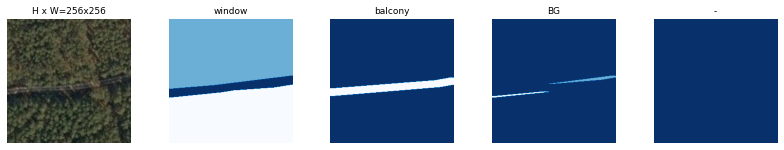

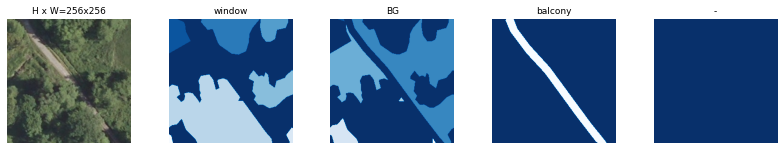

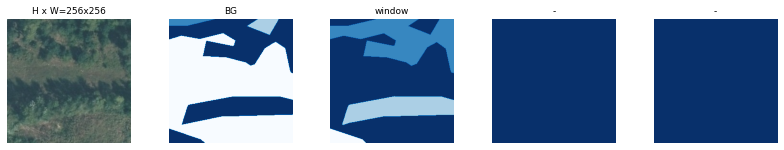

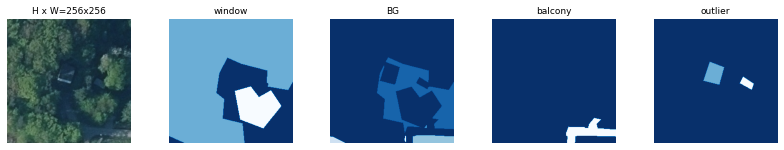

In [ ]:
dataset = dataset_train
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

In [ ]:
class CigButtsConfig(Config):
    """Configuration for training on the cigarette butts dataset.
    Derives from the base Config class and overrides values specific
    to the cigarette butts dataset.
    """
    # Give the configuration a recognizable name
    NAME = "cig_butts"

    # Train on 1 GPU and 1 image per GPU. Batch size is 1 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 5  # background + 1 (cig_butt)

    # All of our training images are 512x512
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256

    # You can experiment with this number to see if it improves training
    STEPS_PER_EPOCH = 500

    # This is how often validation is run. If you are using too much hard drive space
    # on saved models (in the MODEL_DIR), try making this value larger.
    VALIDATION_STEPS = 5
    
    # Matterport originally used resnet101, but I downsized to fit it on my graphics card
    BACKBONE = 'resnet50'

    # To be honest, I haven't taken the time to figure out what these do
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 50 
    POST_NMS_ROIS_INFERENCE = 500 
    POST_NMS_ROIS_TRAINING = 1000 
    
config = CigButtsConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                18
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

In [ ]:
ls

maskToJson/  test/          train.json    val_images/  val_masks/
output/      train_images/  train_masks/  val.json


In [ ]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir='output/')
# model.keras_model.summary()
# print(model_dir)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
box_ind is deprecated, use box_indices instead


In [ ]:
ls

maskToJson/  test/          train.json    val_images/  val_masks/
output/      train_images/  train_masks/  val.json


In [ ]:
print(COCO_MODEL_PATH)
print(MODEL_DIR)


/content/drive/My Drive/Colab Notebooks/Dataset/Data_final_TV/mrcnn/mask_rcnn_coco.h5
/content/drive/My Drive/Colab Notebooks/Dataset/Data_final_TV/mrcnn/logs


In [ ]:
model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc","mrcnn_bbox", "mrcnn_mask"])
print("Weights loaded!")

Weights loaded!


In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.

# model.train(dataset_train, dataset_val, 
#             learning_rate=config.LEARNING_RATE, 
#             epochs=4, 
#             layers='heads',
#             model.save("testRcnn"))

# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=2, 
            layers='all')
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')

currentTime = str((datetime.now()+timedelta(hours=10)).strftime("%d-%m-%Y__%I-%M-%S%p"))
# model.save(f"/content/drive/MyDrive/Colab Notebooks/Dataset/Data_final_TV/logs/model_{currentTime}.hdf5")



Starting at epoch 0. LR=0.001

Checkpoint Path: /content/drive/MyDrive/Colab Notebooks/Dataset/Data_final_TV/onefile/Data_final_TV/mask_rcnn_cig_butts_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res

/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers ma

Epoch 1/2
500/500 [==============================] - 2714s 5s/step - loss: 3.1267 - val_loss: 3.1519



Epoch 2/2
500/500 [==============================] - 2698s 5s/step - loss: 2.7717 - val_loss: 1.4755
Training took 92.1 minutes


In [ ]:
class InferenceConfig(CigButtsConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    DETECTION_MIN_CONFIDENCE = 0.85
    

inference_config = InferenceConfig()

In [ ]:
ls

events.out.tfevents.1634076728.af11fd6f8600  output/        val_images/
events.out.tfevents.1634076824.af11fd6f8600  test/          val.json
mask_rcnn_cig_butts_0001.h5                  train_images/  val_masks/
mask_rcnn_cig_butts_0002.h5                  train.json
maskToJson/                                  train_masks/


In [ ]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

In [ ]:
ls

maskToJson/  test/          train.json    val_images/  val_masks/
output/      train_images/  train_masks/  val.json


In [ ]:
# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = '/content/drive/MyDrive/Colab Notebooks/Dataset/Data_final_TV/mrcnn/mask_rcnn_cig_butts_0002.h5'

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /content/drive/MyDrive/Colab Notebooks/Dataset/Data_final_TV/mrcnn/mask_rcnn_cig_butts_0002.h5


In [ ]:
ls

images/      output/        train.json    val_images/  val_masks/
maskToJson/  train_images/  train_masks/  val.json


Processing 1 images
image                    shape: (256, 256, 3)         min:   35.00000  max:  209.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -88.70000  max:   90.20000  float64
image_metas              shape: (1, 18)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


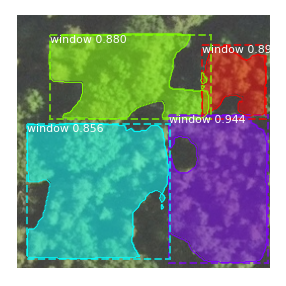

Processing 1 images
image                    shape: (256, 256, 3)         min:   30.00000  max:  229.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -82.70000  max:  102.30000  float64
image_metas              shape: (1, 18)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


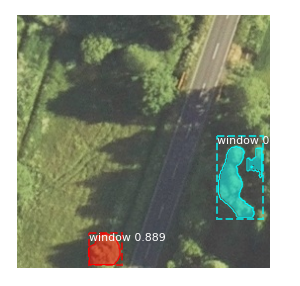

Processing 1 images
image                    shape: (256, 256, 3)         min:   34.00000  max:  228.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -85.70000  max:  101.30000  float64
image_metas              shape: (1, 18)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


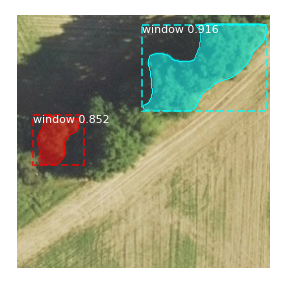

Processing 1 images
image                    shape: (256, 256, 3)         min:   37.00000  max:  216.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -78.70000  max:   96.20000  float64
image_metas              shape: (1, 18)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


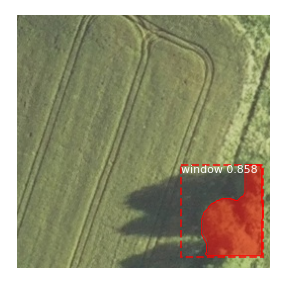

Processing 1 images
image                    shape: (256, 256, 3)         min:   37.00000  max:  204.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -84.70000  max:   83.20000  float64
image_metas              shape: (1, 18)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


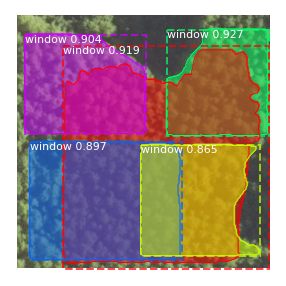

Processing 1 images
image                    shape: (256, 256, 3)         min:   39.00000  max:  227.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -82.70000  max:  106.20000  float64
image_metas              shape: (1, 18)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


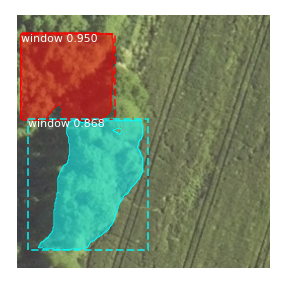

Processing 1 images
image                    shape: (256, 256, 3)         min:   28.00000  max:  216.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -86.70000  max:   95.20000  float64
image_metas              shape: (1, 18)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


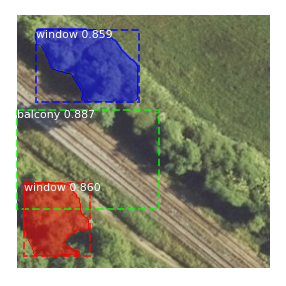

Processing 1 images
image                    shape: (256, 256, 3)         min:   35.00000  max:  213.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -83.70000  max:   92.20000  float64
image_metas              shape: (1, 18)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


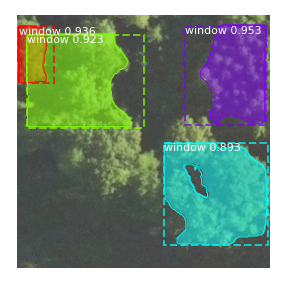

Processing 1 images
image                    shape: (256, 256, 3)         min:   41.00000  max:  201.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -82.70000  max:   82.20000  float64
image_metas              shape: (1, 18)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


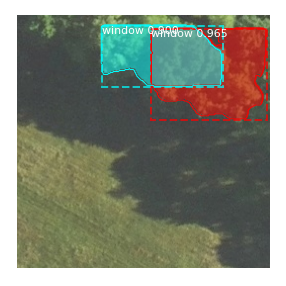

Processing 1 images
image                    shape: (256, 256, 3)         min:   19.00000  max:  190.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -102.70000  max:   67.20000  float64
image_metas              shape: (1, 18)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


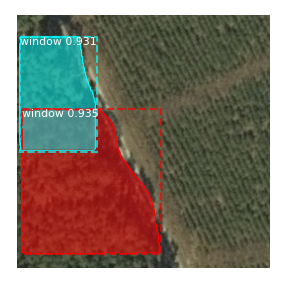

['images/M-33-20-D-d-3-3.tifpatch_352.tif', 'images/M-33-20-D-d-3-3.tifpatch_420.tif', 'images/M-33-20-D-d-3-3.tifpatch_369.tif', 'images/M-33-20-D-d-3-3.tifpatch_419.tif', 'images/M-33-20-D-d-3-3.tifpatch_415.tif', 'images/M-33-20-D-d-3-3.tifpatch_416.tif', 'images/M-33-20-D-d-3-3.tifpatch_238.tif', 'images/M-33-20-D-d-3-3.tifpatch_411.tif', 'images/M-33-20-D-d-3-3.tifpatch_410.tif', 'images/M-33-7-A-d-2-3.tifpatch_013.tif']


In [ ]:
import skimage
real_test_dir = 'images/'
image_paths = []
for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg','.tif']:
        image_paths.append(os.path.join(real_test_dir, filename))

for image_path in image_paths:
    img = skimage.io.imread(image_path)
    img_arr = np.array(img)
    results = model.detect([img_arr], verbose=1)
    r = results[0]
    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, r['scores'], figsize=(5,5))
print(image_paths)